# Introduction to Machine-Learning Assisted Sampling

In this tutorial, we will show how to setup a simulation to sample the NPT ensemble of Aluminium.
To keep the example simple, we will use the EMT potential as reference.

## Setting up the simulation

A MLACS simulations contains 3 ingredients
- The system, which consist in an atomic system and it's associated potential
- A state to be sampled
- A machine-learning interatomic potential

We will start this tutorial by demonstrating the simplest way to set up all these components

### Setting up the system

The first component is the actual system to be simulated.
In this tutorial, we will simulate bulk aluminium with a EMT potential.

As input, we can use the `bulk` function of the ASE package.

In [1]:
from ase.build import bulk
at = bulk("Al", cubic=True).repeat(2)  # This create a 2x2x2 supercell of aluminium

For the potential, we can use the EMT implementation in ASE

In [2]:
from ase.calculators.emt import EMT
calc = EMT()

### Setting up the state

The second ingredient for a MLACS simulation is the state to be sampled.
Usually, the state is defined by the thermostat/barostat used in the molecular dynamics simulation

We will start by setting up some parameters

In [3]:
temperature = 300  # The temperature, in K
pressure = 0.0  # The pressure, in GPa
nsteps = 500  # The number of steps

We also have to provide the path to the LAMMPS binary.
This can be set up using a bash command
```bash
export ASE_LAMMPSRUN_COMMAND=~/.local/bin/lmp
```
or directly in python as we will do here

In [4]:
import os
os.environ["ASE_LAMMPSRUN_COMMAND"] = "~/.local/bin/lmp"

Now, we can import the state, that will consist here in a LAMMPS molecular dynamics with a Langevin thermostat set to 300K and a barostat set to 0 GPa.

In [5]:
from mlacs.state import LammpsState
state = LammpsState(temperature,
                    pressure,
                    nsteps=nsteps)

### Setting up the machine-learning interatomic potential

And the final ingredient is the machine-learning interatomic potential that will drive the molecular dynamics and will be updated from the reference data gathered.

In this example, we will use a SNAP potential with a parameter $2J_{\mathrm{max}}$ of 4 to speed up the simulation.
The setting up of a SNAP potential is done in two steps:
* define the descriptor

In [7]:
from mlacs.mlip import SnapDescriptor
parameters = {"twojmax": 4}
descriptor = SnapDescriptor(at,
                            parameters=parameters)

* Define the model

In [8]:
from mlacs.mlip import LinearPotential
mlip = LinearPotential(descriptor)

## Gathering everything and launching the simulation

Now that everything is set up, we can gather everything into a `OtfMlacs` object

In [9]:
from mlacs import OtfMlacs
dyn = OtfMlacs(at,
               state,
               calc,
               mlip)

    On-the-fly Machine-Learning Assisted Canonical Sampling
======================= version  0.0.12 =====================
date: 06-05-2023  23:00:38


State 1/1 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 300
A Langevin thermostat is used
Pressure (GPa)                          0.0
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       500
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   1.5
Barostat damping parameter (in fs) :    1500.0


True potential parameters:
Calculator : emt
parameters :


Linear potential
Parameters:
-----------
energy coefficient :    1.0
forces coefficient :    1.0
stress coefficient :    1.0
Fit method :            ols

Descriptor used in the potential:
SNAP descriptor
---------------
Elements :
Al
Parameters :
rcut                5.0
chemflag            0
twojmax             4
rfac0               0.99363
rmin0               0.0
switchflag          1
bzerofla

and launch the simulation for 20 steps

In [10]:
dyn.run(20)

Step 0
Running initial step
There are 1 unique configuration in the states 
Computation done, creating trajectories

Computing energy with true potential on training configurations

Step 1

Equilibration step for state 1, configuration 1 for this state


Training new MLIP

number of configurations for training: 2
number of atomic environments for training: 64
RMSE Energy    0.0000 eV/at
MAE Energy     0.0000 eV/at
RMSE Forces    0.0030 eV/angs
MAE Forces     0.0016 eV/angs
RMSE Stress    0.0182 GPa
MAE Stress     0.0140 GPa


Running MLMD
State 1/1 has been launched
Computing energy with the True potential

Step 2

Equilibration step for state 1, configuration 2 for this state


Training new MLIP

number of configurations for training: 3
number of atomic environments for training: 96
RMSE Energy    0.0002 eV/at
MAE Energy     0.0001 eV/at
RMSE Forces    0.0117 eV/angs
MAE Forces     0.0065 eV/angs
RMSE Stress    0.1221 GPa
MAE Stress     0.0925 GPa


Running MLMD
State 1/1 has been lau

And that's it !

The simulations, computed with the reference potential, can be found in the `Trajectory.traj` file

In [13]:
from ase.io import read
confs = read("Trajectory.traj", index=":")

And we can plot for example the energy along the trajectory

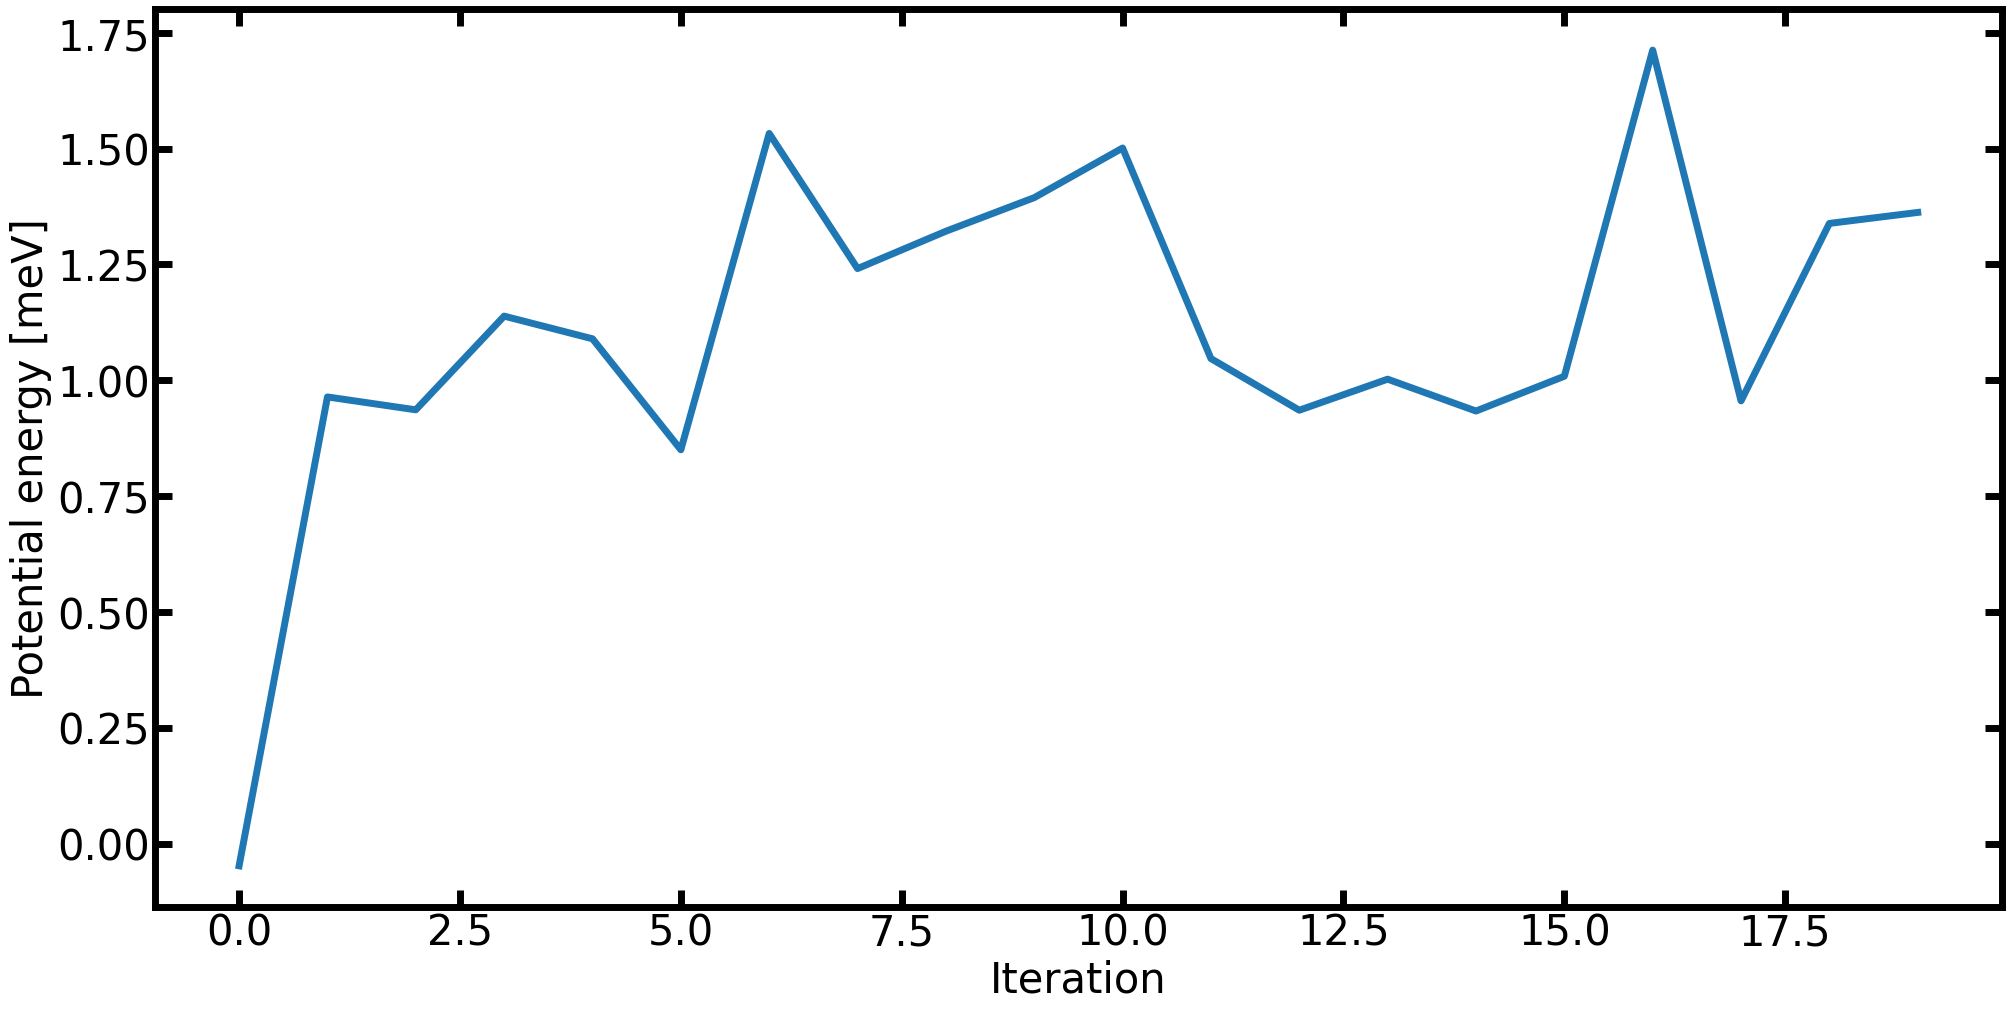

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mlacs.utilities.plots import init_rcParams

x = np.arange(len(confs))
energies = np.array([a.get_potential_energy() for a in confs])

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
init_rcParams()
ax0 = fig.add_subplot()
ax0.set_xlabel("Iteration")
ax0.set_ylabel("Potential energy [meV]")
ax0.plot(x, energies)
plt.show()